# Fit a quadratic function

Here, we are going to sample a quadratic function of this type
```
y = a*x^2 + b*x + c
```
where `a`, `b` and `c` are parameters and `x` is the unique feature.

This example is particularly interesting for our final goal because in the gaussian approximation the $\chi^2$ is a quadratic function of the parameters. Clearly, there are two aspects that are missing w.r.t. a real case scenario:
- usually there is more than one parameter to sample (this is partially covered in the `examples/quadratic_2D`)
- the $\chi^2$ is not exactly a quadratic function. This can be explored only sampling a real world likelihood.

To emulate this function, the main tasks will be:
- generate a sample of data
- build and train a simple architecture
- test what the emulator learned.

NOTE: this example contains enough documentation to learn the basics. In case, refer to `simple_sample.yaml`, `simple_train.yaml`, `planck_sample.yaml` and `planck_train.yaml` for additional information about the parameters to use and the possible choices.

### Load libraries and initialise relevant classes

Load libraries: in this example we are first going to generate a sample (using the Sample class), and then build an emulator (using the FFNNEmu class). Here we are calling diectly the architecture we are going to use (instead of the base class Emulator), but it would be equivalent to call Emulator with a string specifying the type of emulator.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from emu_like.sample import Sample
from emu_like.ffnn_emu import FFNNEmu

2024-01-31 14:02:34.320378: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 14:02:34.323422: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 14:02:34.350940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 14:02:34.350968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 14:02:34.351635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
sample = Sample()
emu = FFNNEmu()

### Generate the sample

Define a dictionary of parameters. This should contain all the parameters that are needed by the function we are going to sample. In this example we are trying to fit a quadratic relation of the type
```
y = a*x^2 + b*x + c
```
as defined in the `quadratic_1D` function in `src/emu_like/sampling_functions.py`.
`x` is the variable we are going to vary, while `a`, `b` and `c` are fixed parameters.

Each fixed parameter should have just a value, while for variables we need to specify
a prior. The `prior` key should contain `min` and `max` parameters in most cases, except for gaussianly distributed priors, where `loc` (mean) and `scale` (standard deviation) keys are expected.

Defining a custom function is relatively simple: just add a new function to `src/emu_like/sampling_functions.py`, mimicking the existing ones.

In [3]:
params = {
  'x': {
      'prior': {
          'min': -80.,
          'max': 80.,
      },
  },
  'a': 1./2.,
  'b': -1.,
  'c': 3.
}

Here we are generating the sample. On top of the previously described `params`, the `generate` method wants to know what is the function we are going to sample (`sampled_function`), the number of samples (`n_samples`) and the spacing (all the possibilities are described in `src/emu_like/samplers.py`). This method gives the possibility to incrementally save progresses (useful when the evaluation of the sampled_function takes some time). In case we want to use this option, it is necessary to specify an `output_path`, i.e. a folder that is going to store the sample.

In [4]:
sample.generate(
    params,
    sampled_function='quadratic_1d',
    n_samples=1000,
    spacing='grid',
    save_incrementally=False,
    output_path=None,
    verbose=True)

[info] Generating sample.
----> Sampled function: quadratic_1d
----> Number of samples: 1000
----> Spacing: grid
[info] Initializing Grid sampler.


100%|██████████| 999/999 [00:00<00:00, 409630.43it/s]


Once the sample is generated, we are going to randomly split it into train and test sample. We have to fix the fractional amount of data for the training sample and the random seed used for the splitting.

In [5]:
sample.train_test_split(
    frac_train=0.9,
    seed=1567,
    verbose=True)

[info] Splitting training and testing samples.
----> Fractional number of training samples: 0.9
----> Random seed for train/test split: 1567


To train more efficiently the emulator it is often useful to rescale both `x` and `y` to have them of order 1. The list of possible scalers can be found at `simple_train.yaml` (or in the source code at `src/emu_like/scalers.py`, where you can also add new scalers).

In [6]:
sample.rescale(
    rescale_x = 'MinMaxScaler',
    rescale_y = 'MinMaxScaler',
    verbose=True)

[info] Rescaling x and y.
----> x with: MinMaxScaler
----> y with: MinMaxScaler
----> Rescaled bounds:
--------> x_train_0 = [0.0, 1.0]
--------> x_test_0 = [0.005010020040080221, 1.001002004008016]
--------> y_train_0 = [0.0, 1.0000000000000002]
--------> y_test_0 = [2.9175842558747805e-05, 0.9803248771609062]


### Build and train the emulator

After the sample is generated, we have to build the emulator architecture and train it.
Building the architecture consists in defining a set of parameters `params` and pass it to the `build` method. The parameters one should specify are listed below, and they are explained in depth in `simple_train.yaml` and `planck_train.yaml`.

In [7]:
params = {
    'activation': 'relu',
    'neurons_hidden': [60, 60],
    'batch_normalization': False,
    'dropout_rate': 0.,
    'batch_size': 32,
    'optimizer': 'adam',
    'loss': 'keras.losses.mse',
    'want_output_layer': True,
    'sample_n_x': sample.n_x,
    'sample_n_y': sample.n_y,
}

In [8]:
emu.build(
    params,
    verbose=True)

[info] Building FFNN architecture
----> Activation function: relu
----> Dropout rate: 0.0
----> Optimizer: adam
----> Loss function: keras.losses.mse
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (32, 60)                  120       
                                                                 
 dense_1 (Dense)             (32, 60)                  3660      
                                                                 
 dense_2 (Dense)             (32, 1)                   61        
                                                                 
Total params: 3841 (15.00 KB)
Trainable params: 3841 (15.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is now time to train the emulator. One has to pass a Sample object (already loaded, splitted into train and test samples and rescaled), the number of `epochs` and the `learning_rate`. It is possible also to save the emulator providing `path`

Epoch 1/2000
29/29 [==============================] - 0s 4ms/step - loss: 0.1141 - val_loss: 0.1018
Epoch 2/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0921 - val_loss: 0.0908
Epoch 3/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0837 - val_loss: 0.0820
Epoch 4/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0773 - val_loss: 0.0753
Epoch 5/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0644
Epoch 6/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0567
Epoch 7/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0513 - val_loss: 0.0483
Epoch 8/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0427 - val_loss: 0.0396
Epoch 9/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0308
Epoch 10/2000
29/29 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0230

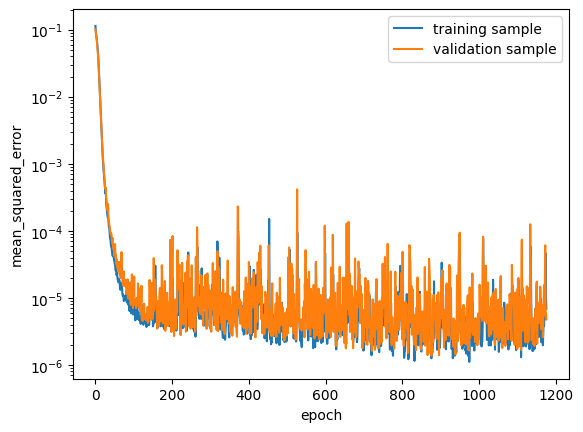

In [9]:
emu.train(
    sample,
    epochs=2000,
    learning_rate=1.e-3,
    path=None,
    get_plot=True,
    verbose=True)

This plot shows the evolution of the loss function per epoch, evaluated for the training sample (`loss`) and the validation sample (`val_loss`). It is possible to notice that both of them start high and then decrease. After reaching a quasi-plateau they start scattering. This indicates that the learning rate could be decreased.

Resuming a training with a different learning rate is very simple. It is sufficient to call the `train` method again with a different `learning_rate`.

Epoch 1178/3177
29/29 [==============================] - 0s 2ms/step - loss: 1.0091e-06 - val_loss: 1.3564e-06
Epoch 1179/3177
29/29 [==============================] - 0s 1ms/step - loss: 8.8447e-07 - val_loss: 1.4670e-06
Epoch 1180/3177
29/29 [==============================] - 0s 1ms/step - loss: 8.9129e-07 - val_loss: 1.4489e-06
Epoch 1181/3177
29/29 [==============================] - 0s 1ms/step - loss: 9.1533e-07 - val_loss: 1.5008e-06
Epoch 1182/3177
29/29 [==============================] - 0s 2ms/step - loss: 9.4817e-07 - val_loss: 1.5547e-06
Epoch 1183/3177
29/29 [==============================] - 0s 2ms/step - loss: 9.9359e-07 - val_loss: 1.3500e-06
Epoch 1184/3177
29/29 [==============================] - 0s 2ms/step - loss: 9.3461e-07 - val_loss: 1.4019e-06
Epoch 1185/3177
29/29 [==============================] - 0s 2ms/step - loss: 8.7981e-07 - val_loss: 1.4501e-06
Epoch 1186/3177
29/29 [==============================] - 0s 1ms/step - loss: 8.9598e-07 - val_loss: 1.3316e-06
E

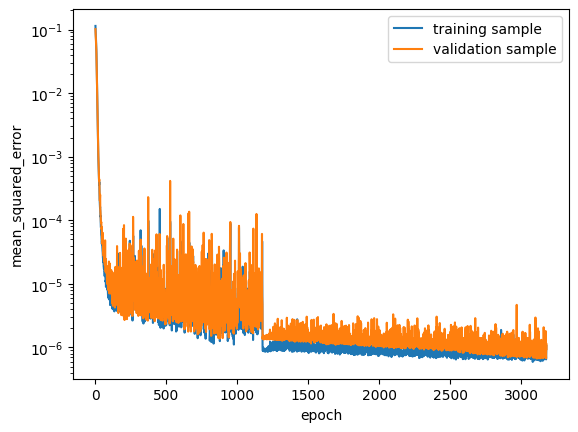

In [10]:
emu.train(
    sample,
    epochs=2000,
    learning_rate=1.e-4,
    path=None,
    get_plot=True,
    verbose=True)

### Testing the result

In 1D we can test the emulator just visually. The first plot shows the sampled data vs the emulated ones. The second plot show the absolute value of the relative difference between the two.

In [11]:
y_emu = np.array([emu.eval(x) for x in sample.x])

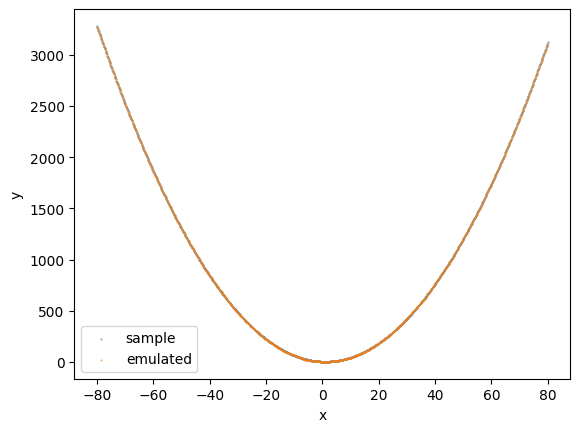

In [12]:
plt.scatter(sample.x[:,0], sample.y[:,0], s=0.1, label='sample')
plt.scatter(sample.x[:,0], y_emu[:,0], s=0.1, label='emulated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

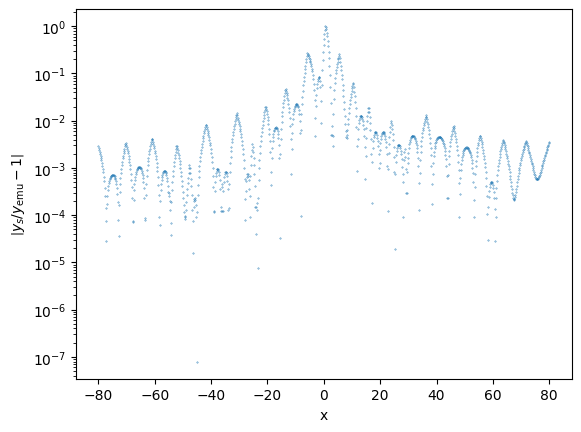

In [13]:
plt.scatter(sample.x[:,0], np.abs(y_emu[:,0]/sample.y[:,0]-1.), s=0.1)
plt.xlabel('x')
plt.ylabel('$\\left|y_s/y_\\mathrm{emu}-1\\right|$')
plt.yscale('log')